In [1]:
# Optimize Sigma Variation with ShareParameters

In [2]:
from desc import set_device
set_device("gpu")

In [3]:
import numpy as np
import os
# os.environ["JAX_LOG_COMPILES"] = "True"
from scipy.io import netcdf_file
import copy
import matplotlib
import matplotlib.pyplot as plt
import scipy
from scipy.constants import mu_0
import sys
import functools
import pickle

import jax
import jax.numpy as jnp
from jax import jit, jacfwd

from netCDF4 import Dataset
import h5py

from desc.backend import put, fori_loop, jnp, sign

from desc.basis import FourierZernikeBasis, DoubleFourierSeries, FourierSeries
from desc.equilibrium import EquilibriaFamily, Equilibrium
from desc.grid import ConcentricGrid, LinearGrid, Grid, QuadratureGrid
from desc.io import InputReader, load
from desc.objectives import *
from desc.objectives.objective_funs import _Objective
from desc.plotting import plot_1d, plot_2d, plot_3d, plot_section, plot_surfaces, plot_comparison

from desc.plotting import *

from desc.transform import Transform
from desc.vmec import VMECIO
from desc.derivatives import Derivative
from desc.geometry import FourierRZToroidalSurface
from desc.profiles import SplineProfile, PowerSeriesProfile

from desc.magnetic_fields import ( SplineMagneticField, 
                                  #biot_savart_general, 
                                  FourierCurrentPotentialField, ToroidalMagneticField,
                                  field_line_integrate)

import desc.examples

from desc.backend import fori_loop, jit, jnp, odeint, sign
from desc.compute import rpz2xyz, rpz2xyz_vec, xyz2rpz, xyz2rpz_vec
from desc.coils import *

from desc.utils import Timer, copy_coeffs, errorif, setdefault, svd_inv_null, warnif
from desc.utils import flatten_list
#from ..utils import cross, dot, safediv, safenorm
#from desc.compute.utils import cross
#from desc.compute.utils import dot

from desc.optimize import lsqtr, lsq_auglag

from scipy.optimize import NonlinearConstraint 

from desc.magnetic_fields import ( SplineMagneticField, 
                                  #biot_savart_general, 
                                  FourierCurrentPotentialField, 
                                  ToroidalMagneticField,
                                  field_line_integrate)

import time

import numpy as np
from numpy.linalg import eig

from scipy.linalg import null_space
from numpy import ndarray


from desc.derivatives import Derivative

DESC version 0.12.3+553.gcb761a802.dirty,using JAX backend, jax version=0.4.35, jaxlib version=0.4.34, dtype=float64

Using device: NVIDIA A100-SXM4-80GB (id=0), with 80.00 GB available memory

In [4]:
#from desc.continuation import solve_continuation_automatic

from desc.objectives import (
    #AspectRatio,
    #FixBoundaryR,
    #FixBoundaryZ,
    #FixCurrent,
    #FixPressure,
    #FixPsi,
    #ForceBalance,
    ObjectiveFunction,
    #QuasisymmetryTwoTerm,
    #RotationalTransform,
    FixParameters, 
    ShareParameters,
    QuadraticFlux, 
    SurfaceCurrentRegularization, 
    bRegularization,
    PlasmaVesselDistance,
    MeanCurvature,
    PrincipalCurvature,
)
from desc.optimize import Optimizer

In [5]:
# Plasma surfaces
eqname_QA = "/home/fcastro/LMStell/regcoil/rogerio/input.QA_final_output.h5" #vacuum equilibrium
eq_QA = desc.io.load(eqname_QA)[4]

eqname_QH = "/home/fcastro/LMStell/regcoil/rogerio/input.QH_final_output.h5" #vacuum equilibrium
eq_QH = desc.io.load(eqname_QH)[4]

In [6]:
G_QA = eq_QA.compute("G")["G"][-1] / mu_0 * 2*np.pi
G_QH = eq_QH.compute("G")["G"][-1] / mu_0 * 2*np.pi

In [7]:
eq = eq_QA

R0 = 1.0
a = 0.3

surf = FourierRZToroidalSurface(R_lmn=[R0,a], 
                                Z_lmn=[-a],
                                modes_R=np.array([[0,0],[1,0]]),
                                modes_Z=np.array([[-1,0]]),
                                NFP=eq.NFP
                               )
surf.change_resolution(N=eq.N)

eq.axis.R_n = eq_QA.axis.R_n + 0.5*(eq_QH.axis.R_n - eq_QA.axis.R_n)
eq.axis.Z_n = eq_QA.axis.Z_n + 0.5*(eq_QH.axis.Z_n - eq_QA.axis.Z_n)

######
for coef, mode in zip(eq.axis.R_n, eq.axis.R_basis.modes):
    n = mode[-1]
    surf.R_lmn=surf.R_lmn.at[surf.R_basis.get_idx(M=0,N=n)].set( coef)
for coef, mode in zip(eq.axis.Z_n, eq.axis.Z_basis.modes):
    n = mode[-1]
    surf.Z_lmn=surf.Z_lmn.at[surf.Z_basis.get_idx(M=0,N=n)].set( coef)

In [8]:
surf1 = surf

surf1.change_resolution(M=12,N=12)

# Generate a Surface Current field for RQA
surf1 = FourierCurrentPotentialField.from_surface(surf1,M_Phi=12,N_Phi=12,sym_Phi=False, I=0, G=G_QA)

# Generate a Surface Current field for RQH
surf2 = surf1.copy()
surf2.G = G_QH

In [9]:
eq_QA.NFP

3

In [10]:
eq_QH.NFP

3

(<Figure size 864x720 with 6 Axes>,
 array([<Axes: title={'center': '$\\phi \\cdot N_{FP}/2\\pi = 0.000$'}, xlabel='$R ~(\\mathrm{m})$', ylabel='$Z ~(\\mathrm{m})$'>,
        <Axes: title={'center': '$\\phi \\cdot N_{FP}/2\\pi = 0.167$'}, xlabel='$R ~(\\mathrm{m})$', ylabel='$Z ~(\\mathrm{m})$'>,
        <Axes: title={'center': '$\\phi \\cdot N_{FP}/2\\pi = 0.333$'}, xlabel='$R ~(\\mathrm{m})$', ylabel='$Z ~(\\mathrm{m})$'>,
        <Axes: title={'center': '$\\phi \\cdot N_{FP}/2\\pi = 0.500$'}, xlabel='$R ~(\\mathrm{m})$', ylabel='$Z ~(\\mathrm{m})$'>,
        <Axes: title={'center': '$\\phi \\cdot N_{FP}/2\\pi = 0.667$'}, xlabel='$R ~(\\mathrm{m})$', ylabel='$Z ~(\\mathrm{m})$'>,
        <Axes: title={'center': '$\\phi \\cdot N_{FP}/2\\pi = 0.833$'}, xlabel='$R ~(\\mathrm{m})$', ylabel='$Z ~(\\mathrm{m})$'>],
       dtype=object))

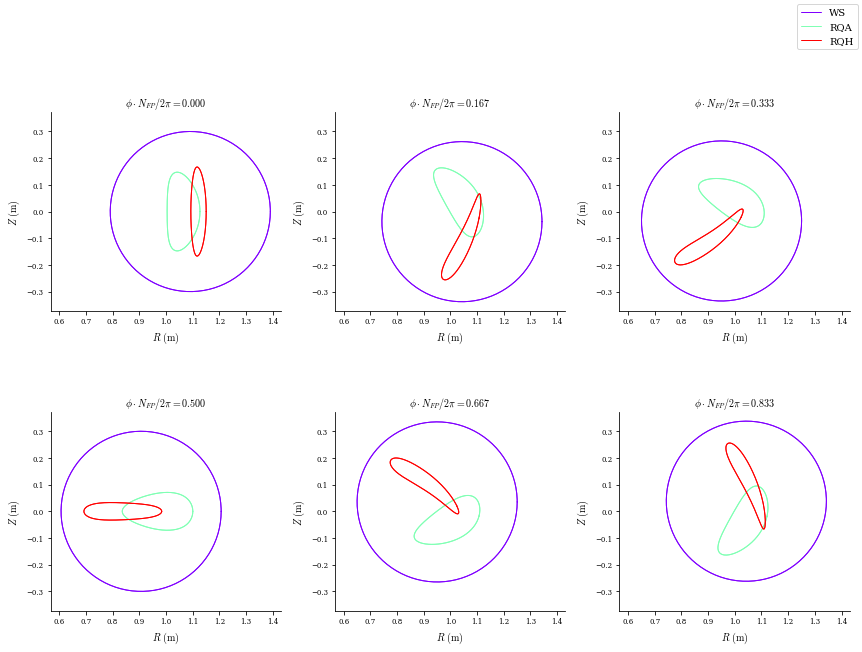

In [11]:
plot_comparison([surf1,eq_QA,eq_QH],
                labels=["WS","RQA","RQH"],
                theta=0,rho=np.array(1.0)
               )

In [12]:
## setup opt problem
# use QuadraticFlux as eq's are fixed and want fields to change
# use ShareParameters to keep surface geoms constant equal to eachother as they vary with surface current to reduce Bn
# first, keep surfs fixed too and just get regcoil-like solutions for each

In [13]:
# Grids
Megrid = 20
Negrid = 20

Msgrid = 20
Nsgrid = 20

egrid = LinearGrid(M=Megrid,N=Negrid,
                   #NFP = 1,
                   NFP=eq.NFP,
                   sym=False)

sgrid = LinearGrid(M=Msgrid,N=Nsgrid,
                   #NFP = 1,
                   NFP=eq.NFP,
                   sym=False) 

In [14]:
flux_QA = QuadraticFlux(eq_QA,surf1,field_grid=sgrid,
                        eval_grid=egrid,vacuum=True,
                        name="Bn error  eq_QA")

flux_QH = QuadraticFlux(eq_QH,surf2,field_grid=sgrid,
                        eval_grid=egrid,vacuum=True,
                        name="Bn error  eq_QH")

In [15]:
obj = ObjectiveFunction((flux_QA,
                         flux_QH,
                        )
                       )
constraints = (
    FixParameters(surf1,{"I":True,"G":True,"R_lmn":True, "Z_lmn":True}),
    FixParameters(surf2,{"I":True,"G":True,"R_lmn":True, "Z_lmn":True}),
) # fix the secular parts as well
                        
opt = Optimizer("lsq-exact")

(surf1, surf2), _ = opt.optimize([surf1, surf2], 
                                 objective=obj, 
                                 constraints=constraints,
                                 verbose=3,
                                 maxiter=5,
                                 ftol = 0,#1e-8,
                                 gtol = 0,#1e-8,
                                 xtol = 0,#1e-8,
                                 options={"initial_trust_radius":np.inf})


Building objective: Bn error  eq_QA

Precomputing transforms

Timer: Precomputing transforms = 1.15 sec

Building objective: Bn error  eq_QH

Precomputing transforms

Timer: Precomputing transforms = 44.7 ms

Timer: Objective build = 1.59 sec

Building objective: fixed parameters

Building objective: fixed parameters

Timer: Objective build = 205 ms

Timer: Linear constraint projection build = 3.02 sec

Number of parameters: 1250

Number of objectives: 3362

Timer: Initializing the optimization = 4.90 sec


Starting optimization

Using method: lsq-exact

   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   

       0              1          3.073e+02                                    2.083e-03   

/home/fcastro/DESC/desc/optimize/least_squares.py:346: RuntimeWarning: invalid value encountered in scalar divide
  alpha *= tr_old / trust_radius


       1              2          4.533e-08      3.073e+02      5.753e+05      1.390e-13   

       2              4          4.533e-08      7.741e-19      8.772e-06      1.378e-13   

       3              5          4.533e-08      1.327e-18      1.745e-05      1.353e-13   

       4              6          4.533e-08      2.633e-18      3.462e-05      1.304e-13   

       5              7          4.533e-08      5.351e-18      6.866e-05      1.209e-13   

         Current function value: 4.533e-08

         Total delta_x: 5.753e+05

         Iterations: 5

         Function evaluations: 7

         Jacobian evaluations: 6

Timer: Solution time = 17.6 sec

Timer: Avg time per step = 2.94 sec

                                                                 Start  -->   End

Total (sum of squares):                                      3.073e+02  -->   4.533e-08, 

Maximum absolute Boundary normal field error:                3.501e-02  -->   2.621e-08 (T m^2)

Minimum absolute Boundary normal field error:                3.129e-17  -->   3.648e-12 (T m^2)

Average absolute Boundary normal field error:                1.035e-02  -->   4.241e-09 (T m^2)

Maximum absolute Boundary normal field error:                3.169e-01  -->   2.373e-07 (normalized)

Minimum absolute Boundary normal field error:                2.832e-16  -->   3.301e-11 (normalized)

Average absolute Boundary normal field error:                9.372e-02  -->   3.839e-08 (normalized)

Maximum absolute Boundary normal field error:                7.879e-02  -->   2.256e-06 (T m^2)

Minimum absolute Boundary normal field error:                3.296e-17  -->   9.960e-17 (T m^2)

Average absolute Boundary normal field error:                2.717e-02  -->   3.080e-07 (T m^2)

Maximum absolute Boundary normal field error:                1.383e+00  -->   3.959e-05 (normalized)

Minimum absolute Boundary normal field error:                5.784e-16  -->   1.748e-15 (normalized)

Average absolute Boundary normal field error:                4.768e-01  -->   5.404e-06 (normalized)

Fixed parameters error:                                      0.000e+00  -->   0.000e+00 (~)

Fixed parameters error:                                      0.000e+00  -->   0.000e+00 (~)

In [16]:
surf1.NFP

3

Text(0.5, 1.0, 'Phi surf2')

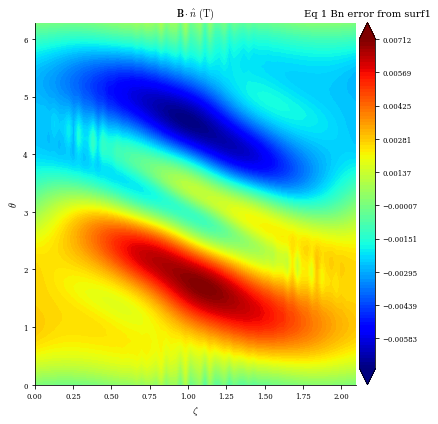

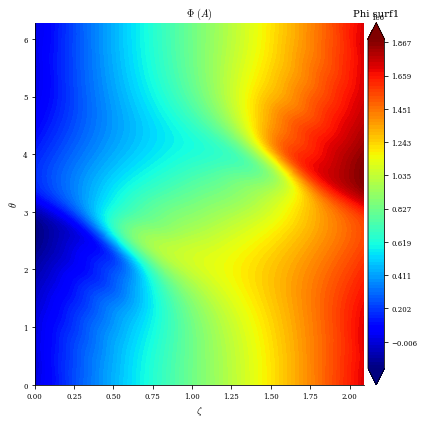

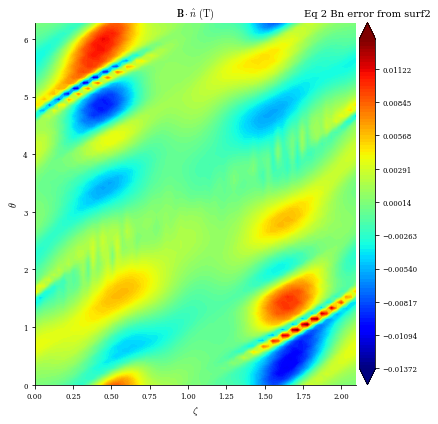

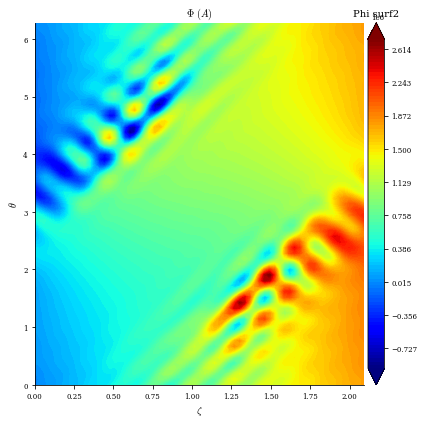

In [17]:
# look at Phi and Bn
denser_source_grid = LinearGrid(M=40,N=40,
                                #NFP=eq_QA.NFP
                               )
plot_2d(eq_QA,"B*n",field=surf1, field_grid=denser_source_grid)
plt.title("Eq 1 Bn error from surf1")

plot_2d(surf1, "Phi")
plt.title("Phi surf1")


plot_2d(eq_QH,"B*n",field=surf2, field_grid=denser_source_grid)
plt.title("Eq 2 Bn error from surf2")
plot_2d(surf2, "Phi")
plt.title("Phi surf2")

In [18]:
## setup opt problem
# use QuadraticFlux as eq's are fixed and want fields to change
# use ShareParameters to keep surface geoms constant equal
# to eachother as they vary with surface current to reduce Bn

In [19]:
# Distance target
min_QA = 0.12
max_QA = 0.2

min_QH = 0.1
max_QH = 0.2

# Distance to veseel penalization
obj_dist_QA = PlasmaVesselDistance(
    eq_QA,
    surf1,
    bounds=(min_QA,max_QA),
    #target = 0.15,
    plasma_grid=egrid,
    surface_grid=sgrid,
    eq_fixed=True,
    #softmin_alpha = 1e6,
    weight = 4.5,
    use_signed_distance=True,
    name="distance error  RQA"
)

obj_dist_QH = PlasmaVesselDistance(
    eq_QH,
    surf1,
    #target = 0.15,
    bounds=(min_QH,max_QH),
    plasma_grid=egrid,
    surface_grid=sgrid,
    eq_fixed=True,
    #softmin_alpha = 1e6,
    use_signed_distance=True,
    weight = 6.5,
    name="distance error  RQH"
)

In [20]:
mean_curv = -0.3
min_mean_curv = 0#-0.5
max_mean_curv = -0.15

obj_mean_curv = MeanCurvature(
    surf1,
    #target = mean_curv,
    bounds = (-15,-10),
    weight=1e0,
    normalize=True,
    normalize_target=True,
    deriv_mode="auto",
    grid=sgrid,
    name="Mean curvature",
)

In [21]:
obj_prin_curv = PrincipalCurvature(surf1,
        #target=None,
        bounds=(-np.inf,0),
        weight=5e-1,
        #normalize=True,
        #normalize_target=True,
        #loss_function=None,
        #deriv_mode="auto",
        grid=sgrid,
        name="principal-curvature",
        #jac_chunk_size=None,
    )

In [22]:
obj = ObjectiveFunction((#flux_QA,
                         #flux_QH,
                         obj_dist_QA,
                         obj_dist_QH,
                         #obj_mean_curv,
                         obj_prin_curv,
                         #surf_curr_reg_QA,
                         #surf_curr_reg_QH,
                         #obj_sigma_QA,
                         #obj_sigma_QH,
                        )
                       )
constraints = (
    #FixParameters(surf1,{"G":True,}),# fix the secular poloidal current
    #FixParameters(surf2,{"G":True,}),# fix the secular poloidal current
    # make the 2 surfaces have the same geometry, dont need bc geom is fixed here
    ShareParameters([surf1,surf2],params={"R_lmn":True, "Z_lmn":True}), 
)

In [23]:
# Choose the optimizer
opt = Optimizer("lsq-exact")

In [24]:
# Run optimization
(surf1, surf2),_ = opt.optimize([surf1, surf2], 
                                 objective=obj, 
                                 constraints=constraints,
                                 verbose=3,
                                 maxiter=80,
                                ftol=0,
                                gtol=0,
                                xtol=0,
                                 options={"initial_trust_radius":np.inf})

Building objective: distance error  RQA

Precomputing transforms

Timer: Precomputing transforms = 129 ms

Building objective: distance error  RQH

Precomputing transforms

Timer: Precomputing transforms = 30.6 ms

Building objective: principal-curvature

Precomputing transforms

Timer: Precomputing transforms = 36.7 ms

Timer: Objective build = 261 ms

Building objective: shared parameters

Timer: Objective build = 4.86 ms

Timer: Linear constraint projection build = 2.25 sec

Number of parameters: 1879

Number of objectives: 5043

Timer: Initializing the optimization = 2.60 sec


Starting optimization

Using method: lsq-exact

   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   

       0              1          8.533e+03                                    5.758e+04   

       1              3          2.948e+03      5.585e+03      9.937e-02      1.138e+04   

       2              4          2.416e+03      5.320e+02      2.763e-02      1.437e+04   

       3              5          2.198e+03      2.176e+02      7.613e-03      7.717e+03   

       4              6          2.135e+03      6.317e+01      9.605e-03      1.200e+04   

       5              7          1.975e+03      1.607e+02      6.157e-03      6.007e+03   

       6              8          1.916e+03      5.841e+01      6.665e-03      6.679e+03   

       7              9          1.833e+03      8.334e+01      5.016e-03      4.943e+03   

       8             10          1.789e+03      4.353e+01      5.462e-03      5.523e+03   

       9             11          1.730e+03      5.921e+01      4.310e-03      4.320e+03   

      10             12          1.698e+03      3.226e+01      4.796e-03      5.457e+03   

      11             13          1.651e+03      4.717e+01      3.707e-03      3.902e+03   

      12             14          1.630e+03      2.106e+01      4.021e-03      6.413e+03   

      13             15          1.595e+03      3.505e+01      3.249e-03      7.188e+03   

      14             16          1.578e+03      1.608e+01      3.082e-03      9.120e+03   

      15             17          1.555e+03      2.308e+01      2.517e-03      1.017e+04   

      16             18          1.533e+03      2.259e+01      2.141e-03      7.587e+03   

      17             19          1.520e+03      1.262e+01      2.221e-03      9.848e+03   

      18             20          1.499e+03      2.167e+01      1.997e-03      7.065e+03   

      19             21          1.487e+03      1.142e+01      2.084e-03      9.507e+03   

      20             22          1.470e+03      1.741e+01      1.977e-03      8.103e+03   

      21             23          1.457e+03      1.302e+01      1.881e-03      8.992e+03   

      22             24          1.443e+03      1.361e+01      1.864e-03      8.027e+03   

      23             25          1.429e+03      1.429e+01      1.759e-03      8.068e+03   

      24             26          1.422e+03      6.807e+00      1.884e-03      8.629e+03   

      25             27          1.405e+03      1.659e+01      4.393e-04      5.167e+03   

      26             28          1.393e+03      1.207e+01      1.033e-03      3.695e+03   

      27             29          1.383e+03      9.989e+00      1.219e-03      3.560e+03   

      28             30          1.375e+03      8.080e+00      1.124e-03      4.908e+03   

      29             31          1.367e+03      7.889e+00      1.060e-03      4.042e+03   

      30             32          1.360e+03      7.251e+00      1.029e-03      4.619e+03   

      31             33          1.353e+03      7.245e+00      1.030e-03      4.465e+03   

      32             34          1.346e+03      6.448e+00      9.953e-04      6.047e+03   

      33             35          1.340e+03      6.042e+00      9.472e-04      5.412e+03   

      34             36          1.334e+03      5.915e+00      9.404e-04      5.764e+03   

      35             37          1.330e+03      4.771e+00      8.910e-04      5.566e+03   

      36             38          1.324e+03      5.978e+00      8.870e-04      5.778e+03   

      37             39          1.320e+03      4.035e+00      8.569e-04      6.144e+03   

      38             40          1.314e+03      5.553e+00      8.648e-04      7.337e+03   

      39             41          1.310e+03      3.730e+00      8.422e-04      6.914e+03   

      40             42          1.305e+03      5.715e+00      2.108e-04      4.484e+03   

      41             43          1.300e+03      4.514e+00      5.057e-04      3.415e+03   

      42             44          1.297e+03      3.062e+00      5.571e-04      3.982e+03   

      43             45          1.293e+03      3.656e+00      5.232e-04      3.832e+03   

      44             46          1.290e+03      3.138e+00      5.245e-04      4.309e+03   

      45             47          1.287e+03      3.390e+00      5.196e-04      3.545e+03   

      46             48          1.284e+03      2.847e+00      5.035e-04      4.753e+03   

      47             49          1.281e+03      2.999e+00      5.019e-04      4.021e+03   

      48             50          1.278e+03      2.575e+00      4.814e-04      4.414e+03   

      49             51          1.276e+03      2.893e+00      4.881e-04      3.744e+03   

      50             52          1.273e+03      2.257e+00      4.677e-04      4.827e+03   

      51             53          1.271e+03      2.809e+00      4.832e-04      4.706e+03   

      52             54          1.268e+03      2.261e+00      4.700e-04      5.452e+03   

      53             55          1.266e+03      2.500e+00      4.691e-04      4.844e+03   

      54             56          1.264e+03      1.898e+00      4.671e-04      5.372e+03   

      55             57          1.262e+03      2.203e+00      4.490e-04      5.370e+03   

      56             58          1.260e+03      1.629e+00      4.464e-04      6.432e+03   

      57             59          1.258e+03      2.181e+00      1.126e-04      5.145e+03   

      58             60          1.256e+03      1.818e+00      2.448e-04      4.002e+03   

      59             61          1.255e+03      1.526e+00      2.772e-04      3.774e+03   

      60             62          1.253e+03      1.401e+00      2.610e-04      5.125e+03   

      61             63          1.252e+03      1.159e+00      2.455e-04      5.275e+03   

      62             64          1.250e+03      1.581e+00      2.469e-04      5.162e+03   

      63             65          1.249e+03      1.124e+00      2.370e-04      4.900e+03   

      64             66          1.248e+03      1.394e+00      2.462e-04      4.763e+03   

      65             67          1.247e+03      1.202e+00      2.770e-04      5.203e+03   

      66             68          1.245e+03      1.154e+00      2.492e-04      5.615e+03   

      67             69          1.244e+03      1.210e+00      2.333e-04      4.873e+03   

      68             70          1.243e+03      1.142e+00      2.402e-04      5.717e+03   

      69             71          1.242e+03      9.968e-01      2.169e-04      6.507e+03   

      70             72          1.241e+03      1.266e+00      2.227e-04      5.285e+03   

      71             73          1.240e+03      1.057e+00      2.231e-04      5.917e+03   

      72             74          1.239e+03      1.115e+00      2.208e-04      5.708e+03   

      73             75          1.238e+03      1.074e+00      2.441e-04      5.731e+03   

      74             76          1.236e+03      1.140e+00      2.381e-04      6.119e+03   

      75             77          1.235e+03      1.027e+00      2.276e-04      5.704e+03   

      76             78          1.234e+03      1.119e+00      2.340e-04      6.586e+03   

      77             79          1.233e+03      1.045e+00      2.179e-04      7.427e+03   

      78             80          1.232e+03      9.249e-01      2.211e-04      7.629e+03   

      79             81          1.231e+03      1.101e+00      2.180e-04      7.140e+03   

      80             82          1.230e+03      1.005e+00      2.345e-04      7.739e+03   

         Current function value: 1.230e+03

         Total delta_x: 1.415e-01

         Iterations: 80

         Function evaluations: 82

         Jacobian evaluations: 81

Timer: Solution time = 46.7 sec

Timer: Avg time per step = 576 ms

                                                                 Start  -->   End

Total (sum of squares):                                      8.533e+03  -->   1.230e+03, 

Maximum Plasma-vessel distance:                              3.257e-01  -->   2.707e-01 (m)

Minimum Plasma-vessel distance:                              8.101e-02  -->   2.598e-02 (m)

Average Plasma-vessel distance:                              2.011e-01  -->   1.663e-01 (m)

Maximum Plasma-vessel distance:                              3.169e+00  -->   2.634e+00 (normalized)

Minimum Plasma-vessel distance:                              7.883e-01  -->   2.528e-01 (normalized)

Average Plasma-vessel distance:                              1.957e+00  -->   1.618e+00 (normalized)

Maximum Plasma-vessel distance:                              3.097e-01  -->   2.284e-01 (m)

Minimum Plasma-vessel distance:                              6.063e-02  -->   1.638e-02 (m)

Average Plasma-vessel distance:                              1.994e-01  -->   1.699e-01 (m)

Maximum Plasma-vessel distance:                              3.235e+00  -->   2.386e+00 (normalized)

Minimum Plasma-vessel distance:                              6.333e-01  -->   1.711e-01 (normalized)

Average Plasma-vessel distance:                              2.083e+00  -->   1.774e+00 (normalized)

Maximum Principal curvature:                                 3.690e+00  -->   9.046e+00 (m^-1)

Minimum Principal curvature:                                 3.092e+00  -->   5.720e-01 (m^-1)

Average Principal curvature:                                 3.377e+00  -->   3.800e+00 (m^-1)

Maximum Principal curvature:                                 1.107e+00  -->   2.714e+00 (normalized)

Minimum Principal curvature:                                 9.275e-01  -->   1.716e-01 (normalized)

Average Principal curvature:                                 1.013e+00  -->   1.140e+00 (normalized)

Shared parameters error:                                     0.000e+00  -->   1.159e-13 (~)

(<Figure size 864x720 with 6 Axes>,
 array([<Axes: title={'center': '$\\phi \\cdot N_{FP}/2\\pi = 0.000$'}, xlabel='$R ~(\\mathrm{m})$', ylabel='$Z ~(\\mathrm{m})$'>,
        <Axes: title={'center': '$\\phi \\cdot N_{FP}/2\\pi = 0.167$'}, xlabel='$R ~(\\mathrm{m})$', ylabel='$Z ~(\\mathrm{m})$'>,
        <Axes: title={'center': '$\\phi \\cdot N_{FP}/2\\pi = 0.333$'}, xlabel='$R ~(\\mathrm{m})$', ylabel='$Z ~(\\mathrm{m})$'>,
        <Axes: title={'center': '$\\phi \\cdot N_{FP}/2\\pi = 0.500$'}, xlabel='$R ~(\\mathrm{m})$', ylabel='$Z ~(\\mathrm{m})$'>,
        <Axes: title={'center': '$\\phi \\cdot N_{FP}/2\\pi = 0.667$'}, xlabel='$R ~(\\mathrm{m})$', ylabel='$Z ~(\\mathrm{m})$'>,
        <Axes: title={'center': '$\\phi \\cdot N_{FP}/2\\pi = 0.833$'}, xlabel='$R ~(\\mathrm{m})$', ylabel='$Z ~(\\mathrm{m})$'>],
       dtype=object))

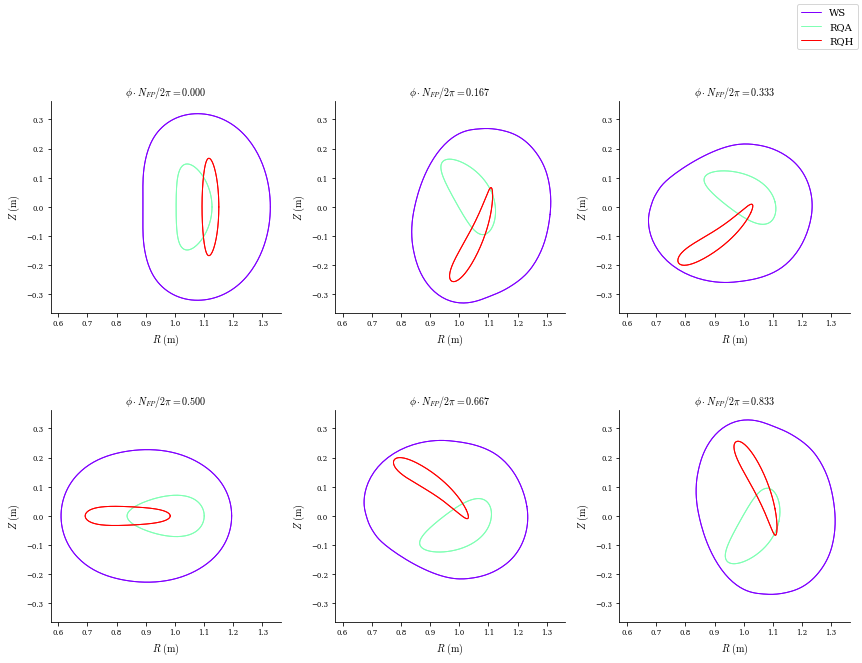

In [25]:
plot_comparison([surf1,eq_QA,eq_QH],
                labels=["WS","RQA","RQH"],
                theta=0,rho=np.array(1.0)
               )

In [26]:
surf1.save("surf_opt.h5")

(<Figure size 864x720 with 6 Axes>,
 array([<Axes: title={'center': '$\\phi \\cdot N_{FP}/2\\pi = 0.000$'}, xlabel='$R ~(\\mathrm{m})$', ylabel='$Z ~(\\mathrm{m})$'>,
        <Axes: title={'center': '$\\phi \\cdot N_{FP}/2\\pi = 0.167$'}, xlabel='$R ~(\\mathrm{m})$', ylabel='$Z ~(\\mathrm{m})$'>,
        <Axes: title={'center': '$\\phi \\cdot N_{FP}/2\\pi = 0.333$'}, xlabel='$R ~(\\mathrm{m})$', ylabel='$Z ~(\\mathrm{m})$'>,
        <Axes: title={'center': '$\\phi \\cdot N_{FP}/2\\pi = 0.500$'}, xlabel='$R ~(\\mathrm{m})$', ylabel='$Z ~(\\mathrm{m})$'>,
        <Axes: title={'center': '$\\phi \\cdot N_{FP}/2\\pi = 0.667$'}, xlabel='$R ~(\\mathrm{m})$', ylabel='$Z ~(\\mathrm{m})$'>,
        <Axes: title={'center': '$\\phi \\cdot N_{FP}/2\\pi = 0.833$'}, xlabel='$R ~(\\mathrm{m})$', ylabel='$Z ~(\\mathrm{m})$'>],
       dtype=object))

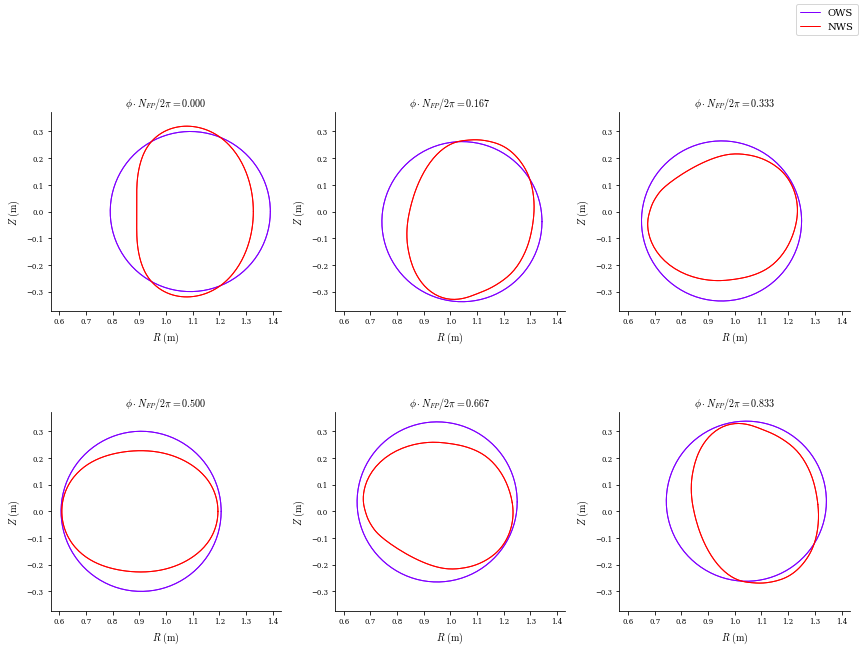

In [27]:
plot_comparison([surf,surf1],
                labels=["OWS","NWS"],
                theta=0,rho=np.array(1.0)
               )